# <center> Speech Emotion Recognition using the RAVDESS AND TESS dataset

## Datasets used

### The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)
#### Audio only files of actors(01-24) are available as two separate file (~200MB each)
#### Speech file (Audio_Speech_Actors_01-24.zip, 215MB) contains 1440 files: 60 trials per actor x 24 actors = 1440
#### Song file (Audio_Song_Actors_01-24.zip, 198MB) contains 1012 files: 44 trials per actor x 23 actors = 1012
#### Total files = 2452

### Toronto Emotional Speech Set (TESS)
#### There are a set of 200 target words were spoken in the carrier phase by two actresses and recordings were made of the set portraying each of 7 emotions (anger, disgust, fear, happiness, pleasant, surprise, sadness, neutral).
#### There are 2800 data points (audio files) in total.
#### The format of audio file is .wav

### Installing Librosa for audio processing

In [1]:
!pip install librosa resampy

Defaulting to user installation because normal site-packages is not writeable


## Define Data Paths

In [2]:
ravdess = "E:/NEW_FOLDER/Projects_Java_Python/Speech Emotion Recognition using various datasets/datasets/RAVDESS"
tess = "E:/NEW_FOLDER/Projects_Java_Python/Speech Emotion Recognition using various datasets/datasets/TESS"

## Import Necessary Libraries

In [3]:
# Essential Libraries
import os
import time
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Librosa for Audio Processing
import librosa
import librosa.display

# Machine Learning & Model Training
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Deep Learning with TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Conv1D, Activation, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop  # Use legacy if needed

# Jupyter Notebook Specific (for inline plotting)
# Comment this out if not using Jupyter Notebook
%matplotlib inline  

#### Loading one audio file from the drive using librosa.
#### Librosa loads the audio file as a floating point time series.

In [4]:
data, sampling_rate = librosa.load("E:/NEW_FOLDER/Projects_Java_Python/Speech Emotion Recognition using various datasets/datasets/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav")

C:\ProgramData\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Plotting the audio file which was just loaded by librosa using waveplot function of librosa.This Function Plots the amplitude envelope of a waveform.

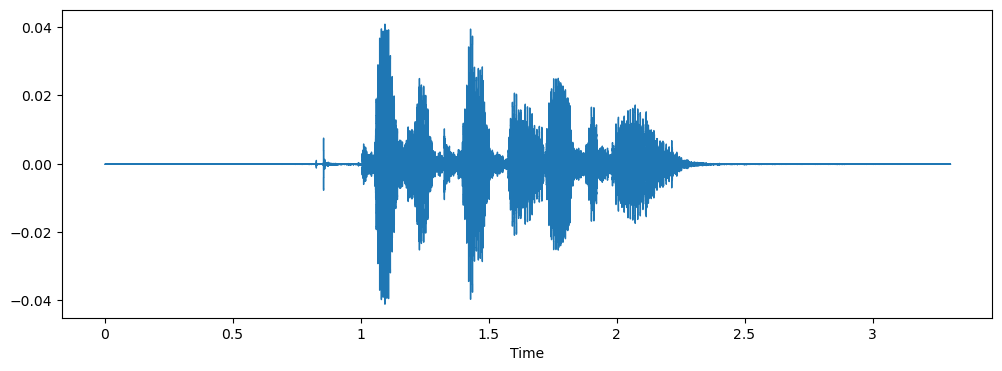

In [5]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)

# Load all files

We will create our numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file (see the introductory section of this notebook to see the naming convention of the files of this dataset).

In [6]:
path = "E:/NEW_FOLDER/Projects_Java_Python/Speech Emotion Recognition using various datasets/datasets/RAVDESS"
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 379.6633687019348 seconds ---


In [7]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [8]:
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((2880, 40), (2880,))

In [9]:
# Saving joblib files to not load them again with the loop above

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = "E:\\NEW_FOLDER\\Projects_Java_Python\\Speech Emotion Recognition using various datasets\\Model"

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [10]:
# Loading saved models
X = joblib.load("E:/NEW_FOLDER/Projects_Java_Python/Speech Emotion Recognition using various datasets/Model/X.joblib")
y = joblib.load("E:/NEW_FOLDER/Projects_Java_Python/Speech Emotion Recognition using various datasets/Model/y.joblib")

#### 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [12]:
best_model = None
best_accuracy = 0

## 1. Convolutional Neural network

In [13]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [14]:
x_traincnn.shape, x_testcnn.shape

((2304, 40, 1), (576, 40, 1))

In [15]:
model = Sequential()

model.add(Conv1D(64, 5, padding='same', input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(128, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(256, 5, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))

# Fixed optimizer
opt = RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07)  # Remove decay

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 64)            384       
                                                                 
 activation (Activation)     (None, 40, 64)            0         
                                                                 
 dropout (Dropout)           (None, 40, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           41088     
                                                                 
 activation_1 (Activation)   (None, 10, 128)           0         
                                                        

In [17]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [18]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
144/144 [==============================] - 4s 12ms/step - loss: 4.6878 - accuracy: 0.1419 - val_loss: 2.3723 - val_accuracy: 0.0868
Epoch 2/200
144/144 [==============================] - 1s 9ms/step - loss: 3.4912 - accuracy: 0.1415 - val_loss: 2.2156 - val_accuracy: 0.2257
Epoch 3/200
144/144 [==============================] - 2s 11ms/step - loss: 2.7930 - accuracy: 0.1762 - val_loss: 1.9641 - val_accuracy: 0.2274
Epoch 4/200
144/144 [==============================] - 1s 9ms/step - loss: 2.5466 - accuracy: 0.1628 - val_loss: 1.9738 - val_accuracy: 0.1979
Epoch 5/200
144/144 [==============================] - 1s 10ms/step - loss: 2.2928 - accuracy: 0.1953 - val_loss: 1.9096 - val_accuracy: 0.2535
Epoch 6/200
144/144 [==============================] - 1s 10ms/step - loss: 2.1808 - accuracy: 0.2049 - val_loss: 1.9332 - val_accuracy: 0.2326
Epoch 7/200
144/144 [==============================] - 2s 10ms/step - loss: 2.1338 - accuracy: 0.2127 - val_loss: 1.8843 - val_accuracy: 0

Epoch 58/200
144/144 [==============================] - 1s 9ms/step - loss: 1.5143 - accuracy: 0.4266 - val_loss: 1.4298 - val_accuracy: 0.4826
Epoch 59/200
144/144 [==============================] - 1s 8ms/step - loss: 1.5087 - accuracy: 0.4423 - val_loss: 1.4414 - val_accuracy: 0.4861
Epoch 60/200
144/144 [==============================] - 1s 7ms/step - loss: 1.4956 - accuracy: 0.4405 - val_loss: 1.4157 - val_accuracy: 0.4948
Epoch 61/200
144/144 [==============================] - 1s 7ms/step - loss: 1.4748 - accuracy: 0.4405 - val_loss: 1.4227 - val_accuracy: 0.4878
Epoch 62/200
144/144 [==============================] - 2s 11ms/step - loss: 1.4614 - accuracy: 0.4527 - val_loss: 1.3875 - val_accuracy: 0.4965
Epoch 63/200
144/144 [==============================] - 1s 10ms/step - loss: 1.4637 - accuracy: 0.4553 - val_loss: 1.4135 - val_accuracy: 0.4948
Epoch 64/200
144/144 [==============================] - 1s 9ms/step - loss: 1.4484 - accuracy: 0.4566 - val_loss: 1.4054 - val_accurac

144/144 [==============================] - 1s 10ms/step - loss: 1.0814 - accuracy: 0.6059 - val_loss: 1.1625 - val_accuracy: 0.5781
Epoch 115/200
144/144 [==============================] - 1s 10ms/step - loss: 1.0942 - accuracy: 0.5994 - val_loss: 1.0977 - val_accuracy: 0.6042
Epoch 116/200
144/144 [==============================] - 1s 10ms/step - loss: 1.0853 - accuracy: 0.6207 - val_loss: 1.0824 - val_accuracy: 0.6267
Epoch 117/200
144/144 [==============================] - 2s 11ms/step - loss: 1.0922 - accuracy: 0.6007 - val_loss: 1.0968 - val_accuracy: 0.6111
Epoch 118/200
144/144 [==============================] - 1s 10ms/step - loss: 1.0752 - accuracy: 0.6172 - val_loss: 1.0694 - val_accuracy: 0.6250
Epoch 119/200
144/144 [==============================] - 2s 10ms/step - loss: 1.0686 - accuracy: 0.6055 - val_loss: 1.0965 - val_accuracy: 0.6059
Epoch 120/200
144/144 [==============================] - 1s 10ms/step - loss: 1.0591 - accuracy: 0.6241 - val_loss: 1.0857 - val_accuracy:

144/144 [==============================] - 1s 10ms/step - loss: 0.7990 - accuracy: 0.7166 - val_loss: 0.8572 - val_accuracy: 0.6979
Epoch 171/200
144/144 [==============================] - 1s 10ms/step - loss: 0.7689 - accuracy: 0.7296 - val_loss: 0.8683 - val_accuracy: 0.7066
Epoch 172/200
144/144 [==============================] - 2s 11ms/step - loss: 0.7698 - accuracy: 0.7287 - val_loss: 0.8530 - val_accuracy: 0.7049
Epoch 173/200
144/144 [==============================] - 1s 10ms/step - loss: 0.7799 - accuracy: 0.7348 - val_loss: 0.8536 - val_accuracy: 0.7170
Epoch 174/200
144/144 [==============================] - 1s 10ms/step - loss: 0.7718 - accuracy: 0.7248 - val_loss: 0.8334 - val_accuracy: 0.7170
Epoch 175/200
144/144 [==============================] - 1s 10ms/step - loss: 0.7564 - accuracy: 0.7409 - val_loss: 0.8351 - val_accuracy: 0.7222
Epoch 176/200
144/144 [==============================] - 1s 10ms/step - loss: 0.7704 - accuracy: 0.7235 - val_loss: 0.8629 - val_accuracy:

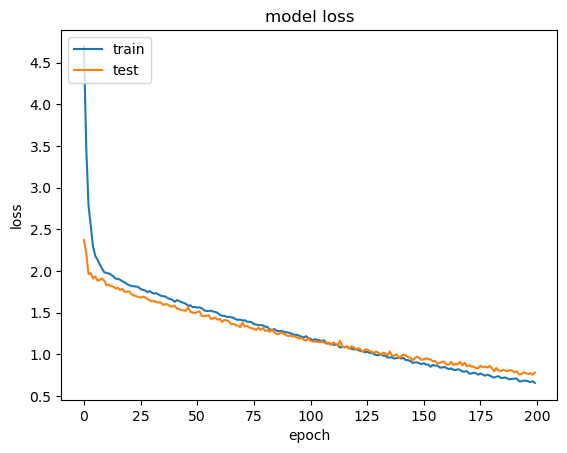

In [19]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

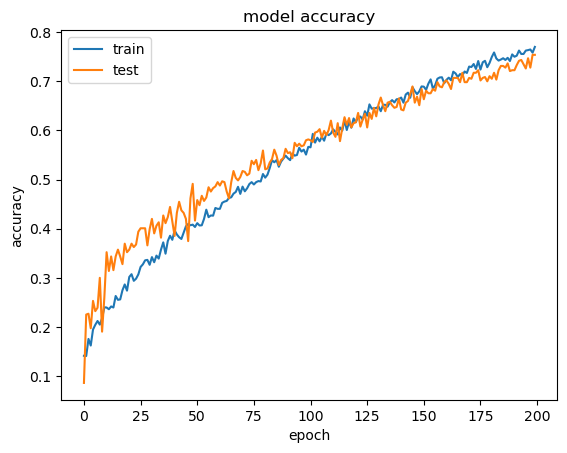

In [20]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
y_pred = np.argmax(model.predict(x_testcnn), axis=1)

18/18 [==============================] - 0s 4ms/step


In [25]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.31      0.43        36
           1       0.72      0.95      0.82        87
           2       0.64      0.82      0.72        66
           3       0.73      0.68      0.70        82
           4       0.79      0.78      0.79        83
           5       0.76      0.80      0.78        65
           6       0.78      0.77      0.77        73
           7       0.92      0.68      0.78        84

    accuracy                           0.75       576
   macro avg       0.76      0.72      0.72       576
weighted avg       0.76      0.75      0.75       576



In [26]:
# Extract accuracy
report = classification_report(y_test, y_pred, output_dict=True)

accuracy = report["accuracy"]

# Print accuracy in percentage format
print(f"Accuracy: {accuracy:.2%}")

# Track Best Model
if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = "cnn"

Accuracy: 75.35%


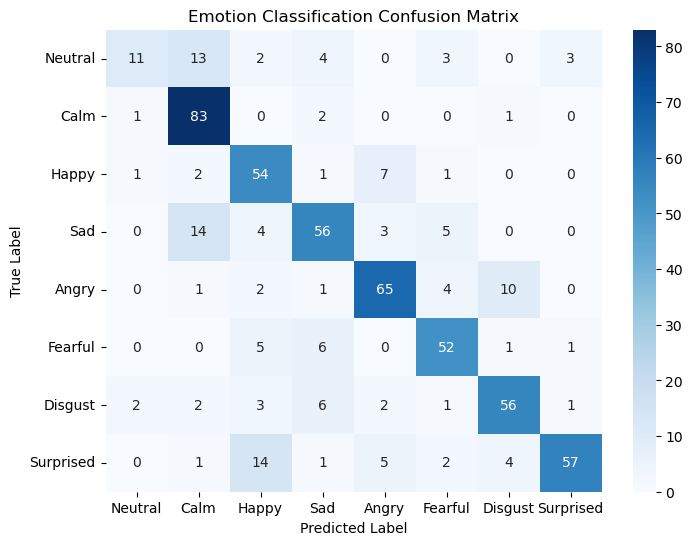

In [28]:
# Define emotion labels
emotion_labels = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

# Generate confusion matrix
matrix = confusion_matrix(y_test, y_pred)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)

# Titles and labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Emotion Classification Confusion Matrix")

# Show plot
plt.show()

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

## 2. K-Nearest Neighbors
## 3. Support Vector
## 4. Random Forest
## 5. Decision Tree Classifier

In [29]:
# Classifiers to Evaluate
classifiers = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVC": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Decision Tree": DecisionTreeClassifier()
}


=== KNN ===
Accuracy: 0.6198
Classification Report:
              precision    recall  f1-score     support
0              0.461538  0.666667  0.545455   36.000000
1              0.771084  0.735632  0.752941   87.000000
2              0.437500  0.530303  0.479452   66.000000
3              0.645161  0.487805  0.555556   82.000000
4              0.705882  0.722892  0.714286   83.000000
5              0.573333  0.661538  0.614286   65.000000
6              0.597015  0.547945  0.571429   73.000000
7              0.708333  0.607143  0.653846   84.000000
accuracy       0.619792  0.619792  0.619792    0.619792
macro avg      0.612481  0.619991  0.610906  576.000000
weighted avg   0.632665  0.619792  0.621863  576.000000


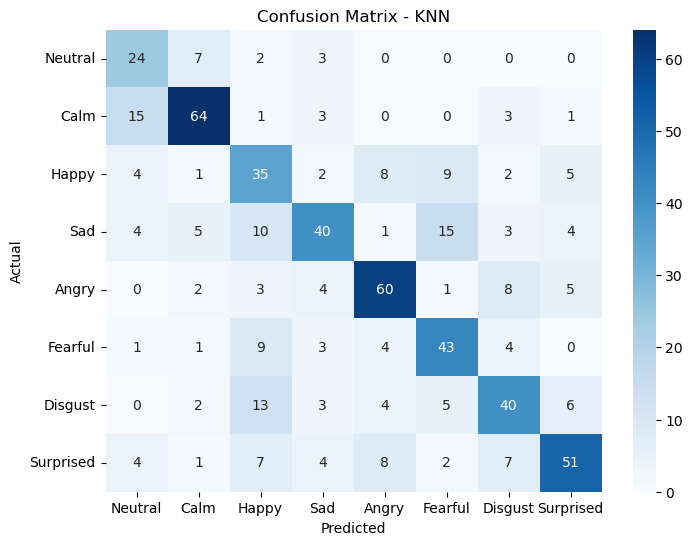


=== SVC ===
Accuracy: 0.5347
Classification Report:
              precision    recall  f1-score     support
0              0.404762  0.472222  0.435897   36.000000
1              0.546392  0.609195  0.576087   87.000000
2              0.397849  0.560606  0.465409   66.000000
3              0.492063  0.378049  0.427586   82.000000
4              0.723684  0.662651  0.691824   83.000000
5              0.533333  0.615385  0.571429   65.000000
6              0.539474  0.561644  0.550336   73.000000
7              0.629630  0.404762  0.492754   84.000000
accuracy       0.534722  0.534722  0.534722    0.534722
macro avg      0.533398  0.533064  0.526415  576.000000
weighted avg   0.548121  0.534722  0.534238  576.000000


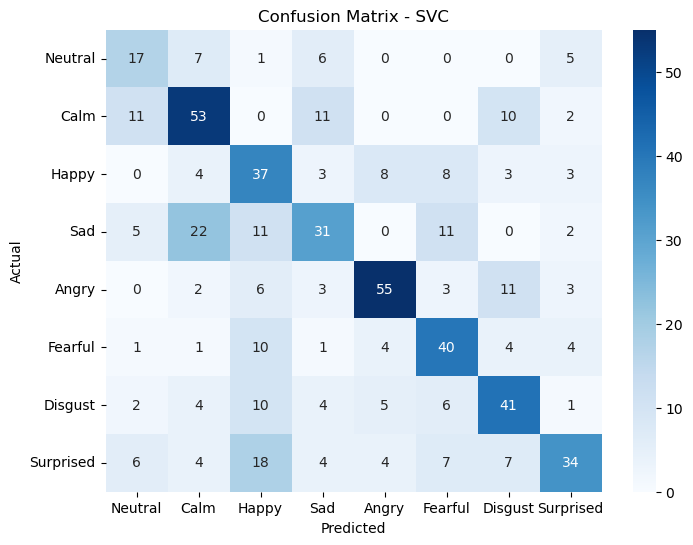


=== Random Forest ===
Accuracy: 0.9097
Classification Report:
              precision    recall  f1-score     support
0              0.933333  0.777778  0.848485   36.000000
1              0.932584  0.954023  0.943182   87.000000
2              0.852941  0.878788  0.865672   66.000000
3              0.894737  0.829268  0.860759   82.000000
4              0.975309  0.951807  0.963415   83.000000
5              0.910448  0.938462  0.924242   65.000000
6              0.896104  0.945205  0.920000   73.000000
7              0.886364  0.928571  0.906977   84.000000
accuracy       0.909722  0.909722  0.909722    0.909722
macro avg      0.910227  0.900488  0.904091  576.000000
weighted avg   0.910412  0.909722  0.909209  576.000000


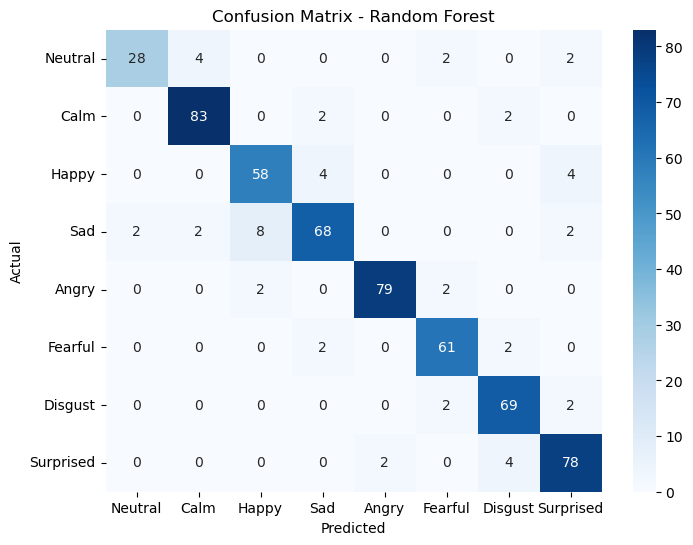


=== Decision Tree ===
Accuracy: 0.8438
Classification Report:
              precision    recall  f1-score    support
0              0.722222  0.722222  0.722222   36.00000
1              0.917808  0.770115  0.837500   87.00000
2              0.800000  0.848485  0.823529   66.00000
3              0.820513  0.780488  0.800000   82.00000
4              0.887640  0.951807  0.918605   83.00000
5              0.792208  0.938462  0.859155   65.00000
6              0.818182  0.863014  0.840000   73.00000
7              0.921053  0.833333  0.875000   84.00000
accuracy       0.843750  0.843750  0.843750    0.84375
macro avg      0.834953  0.838491  0.834501  576.00000
weighted avg   0.847560  0.843750  0.843272  576.00000


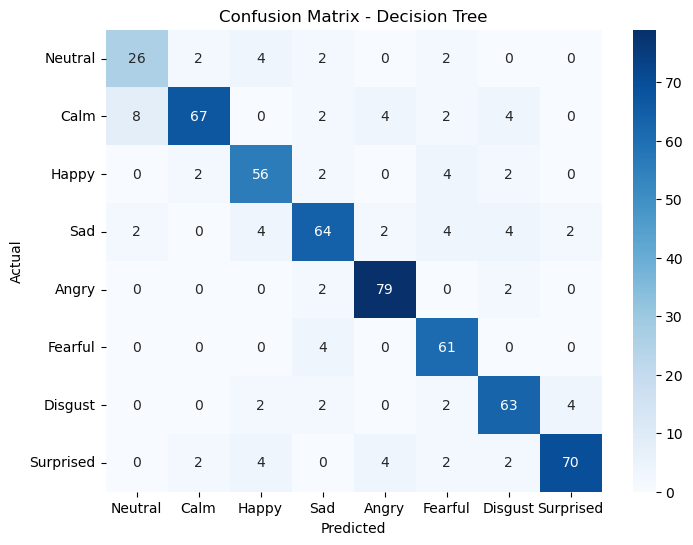

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Store Results
results = {}

# Loop Over Classifiers
for name, model in classifiers.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute Metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)  # Dict for easy access
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Store in Dictionary
    results[name] = {
        "accuracy": accuracy,
        "classification_report": class_report,
        "confusion_matrix": conf_matrix
    }

    # Track Best Model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = name

    # Print Metrics
    print(f"\n=== {name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(pd.DataFrame(class_report).transpose())  # Format as a table

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"], 
                yticklabels=["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [31]:
# Print Best Model
print(f"\n🚀 Best Model: {best_model} with Accuracy: {best_accuracy:.2%}")


🚀 Best Model: Random Forest with Accuracy: 90.97%


In [32]:
# Save Best Model
best_sklearn_model = classifiers[best_model]  # Retrieve best model from dictionary
joblib.dump(best_sklearn_model, "best_model.pkl")
print(f"✅ Best model {best_model} saved as best_model.pkl")

✅ Best model Random Forest saved as best_model.pkl
